In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [37]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [38]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.03505182760501909
Percent Type II errors: 0.15234588106928532

Test set accuracy:
Percent Type I errors: 0.08466257668711656
Percent Type II errors: 0.18159509202453988


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

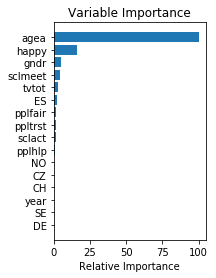

In [9]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [79]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04719039825422804
Percent Type II errors: 0.16721222040370975

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.19631901840490798


## Creating New Features

In [19]:
import seaborn as sns

In [18]:
df.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner'],
      dtype='object')

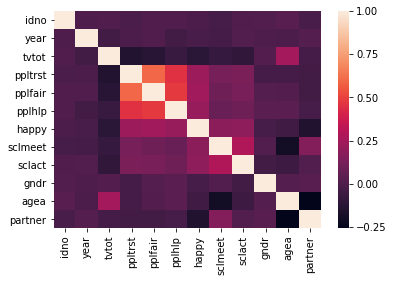

In [20]:
corrmat = df.corr()
sns.heatmap(corrmat)
plt.show()

Age and TV are somewhat correlated. Fairness, trust, and help are all correlated with each other as well.

Meeting is correlated somewhat with having a partner and participating in activities.

(array([1.147e+03, 1.114e+03, 1.437e+03, 1.515e+03, 1.339e+03, 1.012e+03,
        4.600e+02, 1.160e+02, 6.000e+00, 1.000e+00]),
 array([ 15. ,  24.9,  34.8,  44.7,  54.6,  64.5,  74.4,  84.3,  94.2,
        104.1, 114. ]),
 <a list of 10 Patch objects>)

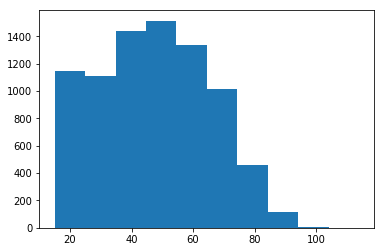

In [21]:
plt.hist(df['agea'])

In [16]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [55]:
#drop year, idno, gndr, pplfair, ppltrust, pplhlp

#Reconfiguring features
df2 = df
df2['partner'] = df2['partner'] - 1
df2['female'] = df2['gndr'] - 1

#adding squared age
df2['age_square'] = df2['agea']**2

#Combining fair, help, trust features.
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
df2['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

In [52]:
df2.columns

Index(['cntry', 'idno', 'year', 'tvtot', 'ppltrst', 'pplfair', 'pplhlp',
       'happy', 'sclmeet', 'sclact', 'gndr', 'agea', 'partner', 'female',
       'age_square', 'trust_fair_help'],
      dtype='object')

In [74]:
from sklearn import preprocessing

df3 = df2[['tvtot','happy', 'sclmeet', 'sclact', 'agea', 'age_square', 'partner', 'female',
       'trust_fair_help']]
df4 = pd.concat([df3, pd.get_dummies(df2['cntry']).astype('int64')], axis=1)

In [69]:
df4.shape

(8147, 15)

In [75]:
df4.dtypes

tvtot              float64
happy              float64
sclmeet            float64
sclact             float64
agea               float64
age_square         float64
partner            float64
female             float64
trust_fair_help    float64
CH                   int64
CZ                   int64
DE                   int64
ES                   int64
NO                   int64
SE                   int64
dtype: object

In [66]:
df4.head()

,tvtot,happy,sclmeet,sclact,agea,age_square,partner,female,trust_fair_help,CH,CZ,DE,ES,NO,SE
0,3.0,8.0,5.0,4.0,60.0,3600.0,0.0,1.0,0.191246,1,0,0,0,0,0
1,6.0,9.0,3.0,2.0,59.0,3481.0,0.0,1.0,0.020453,1,0,0,0,0,0
2,1.0,7.0,6.0,3.0,24.0,576.0,1.0,0.0,1.090626,1,0,0,0,0,0
3,4.0,10.0,6.0,2.0,64.0,4096.0,0.0,1.0,0.321425,1,0,0,0,0,0
4,5.0,8.0,7.0,2.0,55.0,3025.0,0.0,1.0,0.170892,1,0,0,0,0,0


In [88]:
# Definine outcome and predictors.
y = df4['partner']
X = df4.loc[:, ~df4.columns.isin(['partner'])]

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 10,
          'loss': 'deviance',
          'max_features':4}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.08711656441717791
Percent Type II errors: 0.18773006134969325
